##### 导入必要的包

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import glob
import numpy as np
import os
from   lxml import etree
from   matplotlib.patches import Rectangle
from   matplotlib import pyplot as plt
from   PIL import Image
from   torch.optim import lr_scheduler
from   torch.utils import data
from   torchvision import transforms
%matplotlib inline

##### 查看当前PyTorch版本

In [2]:
print(torch.__version__)

1.10.1


##### 尝试读取数据

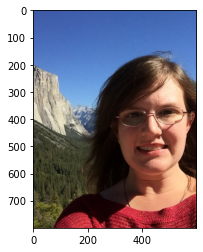

In [3]:
# 显示原图像
pil_img = Image.open(r"./HKdataset/HKdataset/training/00001.png")
np_img  = np.array(pil_img)
plt.imshow(np_img)

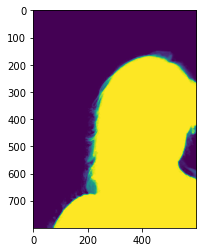

In [4]:
# 显示目标图像
pil_img = Image.open(r"./HKdataset/HKdataset/training/00001_matte.png")
np_img  = np.array(pil_img)
plt.imshow(np_img)

In [5]:
# 查看蒙版图像的像素种类数目
np_img.max()

255

In [6]:
# 查看蒙版图像的像素种类数目
np.unique(np_img)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

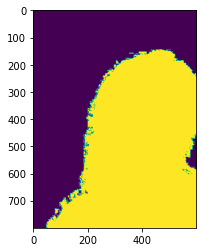

In [7]:
# 将目标图像二值化  目标图像二值化后会增加边缘处的噪声
np_img[np_img>0]  = 1
np_img[np_img<=0] = 0
plt.imshow(np_img)

In [8]:
# 查看二值化后的蒙版图像的像素种类数目
np.unique(np_img)

array([0, 1], dtype=uint8)

In [9]:
# 查看图像的大小
np_img.shape

(800, 600)

##### 创建DataSet

In [10]:
''' 构建训练数据集标签/图片路径 '''
all_pictures      = glob.glob(r"./HKdataset/HKdataset/training/*.png")
images            = [p for p in all_pictures if "matte" not in p]
annotations       = [p for p in all_pictures if "matte" in p]
''' 设置随机种子，同步乱序 '''
np.random.seed(2021)
index             = np.random.permutation(len(images))
images            = np.array(images)[index]
annotations       = np.array(annotations)[index]
''' 构建测试数据集标签/图片路径 '''
all_test_pictures = glob.glob(r"./HKdataset/HKdataset/testing/*.png")
test_images       = [p for p in all_pictures if "matte" not in p]
test_annotations  = [p for p in all_pictures if "matte" in p]
''' 创建transform '''
transform         = transforms.Compose([
    transforms.Resize([256,256]),
    transforms.ToTensor()
])

In [11]:
class HK_DataSet(data.Dataset):
    def __init__(self,imgs_path,annos_path):
        self.imgs_path = imgs_path
        self.annos_path= annos_path
    
    def __getitem__(self,index):
        img        = self.imgs_path[index]
        anno       = self.annos_path[index]
        
        pil_img    = Image.open(img)
        img_tensor = transform(pil_img)
                               
        anno_img   = Image.open(anno)
        anno_tensor= transform(anno_img)
        anno_tensor[anno_tensor>0] = 1
        anno_tensor= torch.squeeze(anno_tensor).type(torch.LongTensor)
        
        return img_tensor,anno_tensor
    
    def __len__(self):
        return len(self.imgs_path)

In [12]:
train_ds = HK_DataSet(images,annotations)
test_ds  = HK_DataSet(test_images,test_annotations)
train_dl = data.DataLoader(train_ds,batch_size=6,shuffle=True)
test_dl  = data.DataLoader(test_ds,batch_size=6)

##### 取出数据集中的数据并查看

In [13]:
img_batch,anno_batch = next(iter(train_dl))
''' 此前的处理将anno中的图片squeeze过,所以这里的数据的torch.Size=([8, 256, 256]) '''
print(img_batch.shape,"\n",anno_batch.shape)

torch.Size([6, 3, 256, 256]) 
 torch.Size([6, 256, 256])


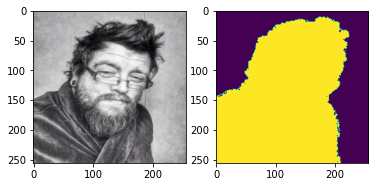

In [14]:
img = img_batch[0].permute(1,2,0).numpy()
anno= anno_batch[0].numpy() # anno是256X256的图像，不必转换

plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(anno)

##### 创建模型

In [15]:
## 根据实际的UNET实现的需求，将不同的UNET部分使用函数来模块化实现

In [16]:
class downSample(nn.Module):
    ''' 定义下采样模型 '''
    def __init__(self,in_channels,out_channels):
        super(downSample,self).__init__()
        self.conv_relu = nn.Sequential(
                         nn.Conv2d(in_channels,out_channels,kernel_size=(3,3),padding=1),
                         nn.ReLU(),
                         nn.Conv2d(out_channels,out_channels,kernel_size=(3,3),padding=1),
                         nn.ReLU()
        )
        self.pool      = nn.MaxPool2d(kernel_size=(2,2))
    
    def forward(self,x,is_pool=True):
        if is_pool:
            '''做下采样'''
            x = self.pool(x)
        x = self.conv_relu(x)
        return x

In [17]:
class upSample(nn.Module):
    ''' 定义上采样模型 '''
    def __init__(self,channels):
        '''
            上采样后的结果层数是输入层数的一半，channels为卷积的channels
            而输出的channels为原channels的一半
        '''
        super(upSample,self).__init__()
        '''上采样的第一部分'''
        self.conv_relu = nn.Sequential(
                         nn.Conv2d(2*channels,channels,kernel_size=(3,3),padding=1),
                         nn.ReLU(inplace=False),
                         nn.Conv2d(channels,channels,kernel_size=(3,3),padding=1),
                         nn.ReLU(inplace=False)
        )
        '''上采样的第二部分'''
        self.upconv    = nn.Sequential(
                         nn.ConvTranspose2d(channels,channels//2,kernel_size=(3,3),stride=2,padding=1,output_padding=1),#内置反卷积层
        )
        
    
    def forward(self,x):
        x = self.conv_relu(x)
        x = self.upconv(x)
        return x

In [18]:
class Unet_Model(nn.Module):
    def __init__(self):
        super(Unet_Model,self).__init__()
        
        self.down_1 = downSample(3,64)                      #  彩色图像下采样 输入为三通道
        self.down_2 = downSample(64,128)
        self.down_3 = downSample(128,256)
        self.down_4 = downSample(256,512)
        self.down_5 = downSample(512,1024)
        
        self.up     = nn.Sequential(                         # 上采样
                      nn.ConvTranspose2d(1024,512,
                                         kernel_size=(3,3),
                                         stride=2,
                                         padding=1,
                                         output_padding=1
                                        ),
                      nn.ReLU(inplace=True)
        )
        
        self.up_1   = upSample(512)
        self.up_2   = upSample(256)
        self.up_3   = upSample(128)
        
        self.conv_2 = downSample(128,64)
        
        self.last   = nn.Conv2d(64,2,kernel_size=(1,1))     #    二分类
    
    def forward(self,input):
        x1 = self.down_1(input,is_pool=False)
        x2 = self.down_2(x1)
        x3 = self.down_3(x2)
        x4 = self.down_4(x3)
        x5 = self.down_5(x4)
        
        # 对中间特征进行重复利用后进行上采样
        x5 = self.up(x5)
        
        x5 = torch.cat([x4,x5],dim=1)                      #    在pytorch中沿着channel所在的维度进行合并
        x5 = self.up_1(x5)                                 #    上采样
        
        x5 = torch.cat([x3,x5],dim=1)                      #    在pytorch中沿着channel所在的维度进行合并
        x5 = self.up_2(x5)
        
        x5 = torch.cat([x2,x5],dim=1)                      #    在pytorch中沿着channel所在的维度进行合并
        x5 = self.up_3(x5)
        
        x5 = torch.cat([x1,x5],dim=1)                      #     合并后进入卷积层
        
        x5 = self.conv_2(x5,is_pool=False)
        
        x5 = self.last(x5)
        return x5        

##### 定义模型

In [19]:
model            = Unet_Model()
model            = model.to("cuda")

In [20]:
loss_fn          = nn.CrossEntropyLoss()
optim            = torch.optim.Adam(model.parameters(),lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optim,step_size=7,gamma=0.1) #   定义学习速率衰减
train_loss       = []
train_acc        = []
test_loss        = []
test_acc         = []
epoches          = 20

In [21]:
def fit(model,trainloader,testloader,epoch):
    correct = 0       # 记录正确率
    total   = 0       # 记录训练样本总数量
    running_loss = 0
    
    model.train()     # 设置为训练模式 表示DropOut会起作用
    
    for x,y in trainloader:
        y      = torch.tensor(y,dtype=torch.long)
        x,y    = x.to("cuda"),y.to("cuda")
        y_pred = model(x)
        loss   = loss_fn(y_pred,y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred,dim=1)
            correct+=(y_pred == y).sum().item()
            total  += y.size(0)
            running_loss += loss.item()
    
    exp_lr_scheduler.step()
    epoch_loss = running_loss / len(trainloader.dataset) # 得到每一个样本在本epoch下的平均loss
    epoch_acc  = correct / (total*256*256)               # 得到整个样本的平均预测正确率
    
    test_correct      = 0        # 记录正确率
    test_total        = 0        # 记录训练样本总数量
    test_running_loss = 0
    
    model.eval()                 # 将模型修改为预测模式 表示DropOut失效 注意在验证数据集上不需要进行Dropout
    
    with torch.no_grad():
        for x,y in testloader:
            y      = torch.tensor(y,dtype=torch.long)
            x,y    = x.to("cuda"),y.to("cuda")
            y_pred = model(x)
            loss   = loss_fn(y_pred,y)
            y_pred = torch.argmax(y_pred,dim=1)
            test_correct+=(y_pred == y).sum().item()
            test_total  += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset) # 得到每一个样本在本epoch下的平均loss
    epoch_test_acc  = test_correct / (test_total*256*256)         # 得到整个样本的平均预测正确率
    
    print(
            "epoch:","\t",epoch,"\t",
            "loss: ","\t",round(epoch_loss,3),"\t",
            "accuracy: ","\t",round(epoch_acc,3),"\t",
            "test_loss: ","\t",round(epoch_test_loss,3),"\t",
            "test_accuracy: ","\t",round(epoch_test_acc,3),"\t"
        )
    return epoch_loss,epoch_acc,epoch_test_loss,epoch_test_acc

In [ ]:
for epoch in range(epoches):
    epoch_loss,epoch_acc,epoch_test_loss,epoch_test_acc = fit(model,train_dl,test_dl,epoch)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

C:\Users\20613\AppData\Local\Temp\ipykernel_7152\267899832.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y      = torch.tensor(y,dtype=torch.long)
C:\Users\20613\AppData\Local\Temp\ipykernel_7152\267899832.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y      = torch.tensor(y,dtype=torch.long)


epoch: 	 0 	 loss:  	 0.095 	 accuracy:  	 0.716 	 test_loss:  	 0.086 	 test_accuracy:  	 0.753 	
epoch: 	 1 	 loss:  	 0.101 	 accuracy:  	 0.708 	 test_loss:  	 0.09 	 test_accuracy:  	 0.732 	
epoch: 	 2 	 loss:  	 0.09 	 accuracy:  	 0.747 	 test_loss:  	 0.085 	 test_accuracy:  	 0.758 	
epoch: 	 3 	 loss:  	 0.084 	 accuracy:  	 0.764 	 test_loss:  	 0.082 	 test_accuracy:  	 0.768 	
epoch: 	 4 	 loss:  	 0.083 	 accuracy:  	 0.765 	 test_loss:  	 0.081 	 test_accuracy:  	 0.77 	
epoch: 	 5 	 loss:  	 0.082 	 accuracy:  	 0.768 	 test_loss:  	 0.08 	 test_accuracy:  	 0.778 	
epoch: 	 6 	 loss:  	 0.08 	 accuracy:  	 0.776 	 test_loss:  	 0.084 	 test_accuracy:  	 0.76 	
epoch: 	 7 	 loss:  	 0.078 	 accuracy:  	 0.784 	 test_loss:  	 0.077 	 test_accuracy:  	 0.786 	
epoch: 	 8 	 loss:  	 0.078 	 accuracy:  	 0.786 	 test_loss:  	 0.077 	 test_accuracy:  	 0.788 	


##### 保存模型

In [ ]:
PATH     = 'unet_model.pth'
torch.save(model.state_dict(),PATH)··

##### Unet模型测试

In [ ]:
# 得到模型
my_model = Unet_Model()
# 恢复权重
my_model.load_state_dict(torch.load(PATH))

In [ ]:
# 在test数据集上进行预测
num                  = 3
img_batch,mask_batch = next(iter(test_dl))                        # 取出测试数据集中的一个批次的数据
# 预测结果
pred_batch           = my_model(img_batch)
plt.figure(figsize=(10,10))                                       # 创建画布进行绘图
for i in range(num):
    plt.subplot(3,3,i*num+1)
    plt.imshow(img_batch[i].permute(1,2,0).cpu().numpy())
    plt.subplot(3,3,i*num+2)
    plt.imshow(mask_batch[i].cpu().numpy())
    plt.subplot(3,3,i*num+3)
    plt.imshow(torch.argmax(pred_batch[i].permute(1,2,0),axis=-1).detach().numpy())  # detach() <==> data  